# An Introduction to Machine Learning with Scikit-learn

### By Luisa Lucie-Smith
#### Credit: Michelle Lochner

First we need to import some tools from scikit learn and the classifiers we're going to use

In [1]:
from __future__ import division, print_function
from sklearn.datasets import make_circles

from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from scipy.integrate import trapz

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib nbagg  

In [2]:
def plot_roc(fpr, tpr):
    """
    Simple ROC curve plotting function.
    
    Parameters
    ----------
    fpr : array
        False positive rate
    tpr : array
        True positive rate
    """
    
    plt.plot(fpr, tpr, lw=1.5)
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

## Generating data

Scikit learn has several built in datasets as well as functions to generate random data. We'll use one of these for this example but it's straightforward to put in your own data.

In [3]:
# X is the array of features, y is the array of corresponding class labels
X, y = make_circles(n_samples=1000, noise=0.1, random_state=0)

To avoid overfitting, we split the data into a training set, used to train the algorithm, and a test set, used to evaluate its performance. There's no hard and fast rule about how big your training set should be, as this is highly problem-dependent. Here, we'll use 70% of the data as training data.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

You should always rescale your features as many algorithms (including SVM and many neural network implementations) assume the features have zero mean and unit variance. They will likely underperform without scaling. In this example, the generated data are already scaled so it's unnecessary, but I leave this in to show you how it's done.

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now we can have a look at our training data, where I've coloured the points by the class they belong to.

<IPython.core.display.Javascript object>


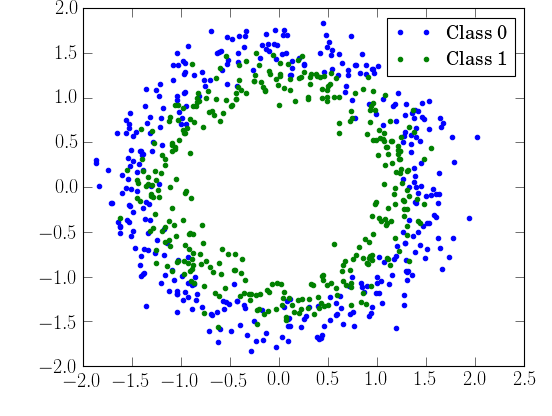

In [6]:
plt.figure()
plt.plot(X_train[y_train==0,0], X_train[y_train==0,1],'.')
plt.plot(X_train[y_train==1,0], X_train[y_train==1,1],'.')
plt.legend(('Class 0', 'Class 1'))

## Classification

Let's start classifying! Scikit-learn is fully object-oriented so each classifier is an object. While there are dozens of different algorithms available, they all behave in the same way, implementing the same functions, meaning it's very easy to swap classifiers in and out.

Here we create a Random Forest classifier object, which has several hyperparameters that are set to default values.

In [7]:
clf = RandomForestClassifier()
print(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)



This is the function that actually trains the classifier with our training data. 

In [8]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now that the classifier is trained, we can use it to predect the classes of our test data and have a look at the accuracy.

In [9]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.833333333333


But since the accuracy is only part of the story, let's get out the probability of belonging to each class so that we can generate the ROC curve.

In [10]:
probs = clf.predict_proba(X_test)

In [14]:
fpr, tpr, thresh = roc_curve(y_test, probs[:,1], pos_label=1)
auc = roc_auc_score(y_test, probs[:,1])
print('Area under curve', auc_rf)

Area under curve 0.897886540601


<IPython.core.display.Javascript object>


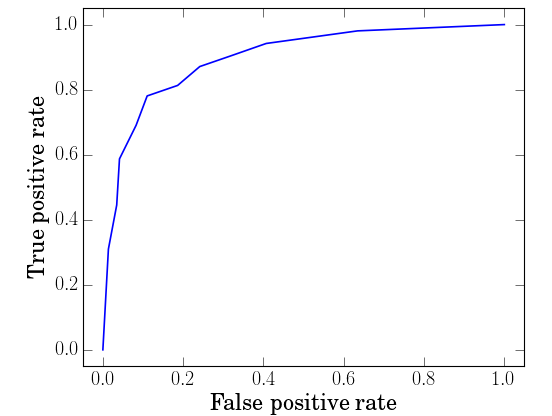

In [15]:
plt.figure()
plot_roc(fpr, tpr)

## Optimising hyperparameters

The K-nearest neighbours classifier has several hyperparameters that we've just left as default. If we optimise these instead, we get a better result. The most robust way to do this is with one of scikit-learn's cross validation methods. Here we'll use GridSearchCV. Naturally now the algorithm will take much longer to train as it has to train and evaluate performance several times.

In [16]:
t1 = time.time()
clf = RandomForestClassifier()

# Define a grid of parameters over which to search, as a dictionary
param_grid = {"n_estimators": [50, 60, 100],
              "max_features": ["auto", 0.4],
              "min_samples_leaf": [15, 20],
              }

# cv=5 means we're doing 5-fold cross validation.
clf = GridSearchCV(clf, param_grid, cv=5)
clf.fit(X_train, y_train)
print('Time taken',time.time()-t1,'seconds')

Time taken 5.148235082626343 seconds


In [17]:
# We can see what were the best combination of parameters
print(clf.best_params_)

{'min_samples_leaf': 15, 'n_estimators': 60, 'max_features': 'auto'}


Let's see if the accuracy has improved

In [18]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.833333333333


The accuracy is more or less unchanged, but we do get a slightly better ROC curve

In [19]:
probs = clf.predict_proba(X_test)

In [21]:
fpr_rf, tpr_rf, thresh = roc_curve(y_test, probs[:,1], pos_label=1)
auc_rf = roc_auc_score(y_test, probs[:,1])
print('Area under curve', auc_rf)

Area under curve 0.899332591769


<IPython.core.display.Javascript object>


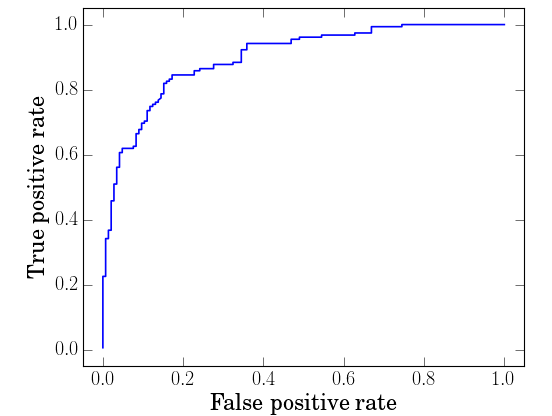

In [22]:
plt.figure()
plot_roc(fpr_rf, tpr_rf)

## Using a different algorithm

Scikit-learn is designed to let you easily swap algorithms out

In [23]:
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.86


In [25]:
probs = clf.predict_proba(X_test)
fpr_svm, tpr_svm, thresh = roc_curve(y_test, probs[:,1], pos_label=1)
auc_svm = roc_auc_score(y_test, probs[:,1])
print('Area under curve', auc_svm)

Area under curve 0.939532814238


<IPython.core.display.Javascript object>


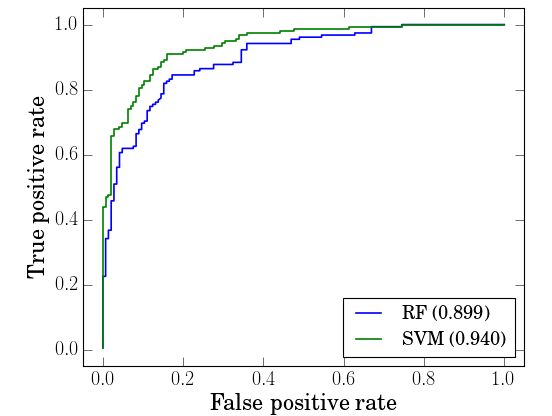

In [26]:
plt.figure()
plot_roc(fpr_rf, tpr_rf)
plot_roc(fpr_svm, tpr_svm)
plt.legend(('RF (%.3f)' %auc_rf, 'SVM (%.3f)' %auc_svm), loc='lower right')

## Over-fitting

This is a somewhat contrived example to demonstrate over-fitting.

First we make some fake data with a few outliers in it.

<IPython.core.display.Javascript object>


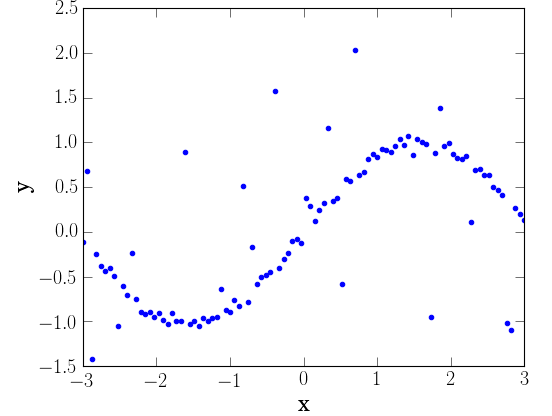

In [27]:
np.random.seed(42)
x = np.linspace(-3,3, 100)
y = np.sin(x) + np.random.randn(len(x))*0.05
N = 25
outlier_ints = np.random.randint(0, len(x), N)
y[outlier_ints] += np.random.randn(N)*1
plt.figure()
plt.plot(x,y,'.')
plt.xlabel('x');
plt.ylabel('y');

<IPython.core.display.Javascript object>


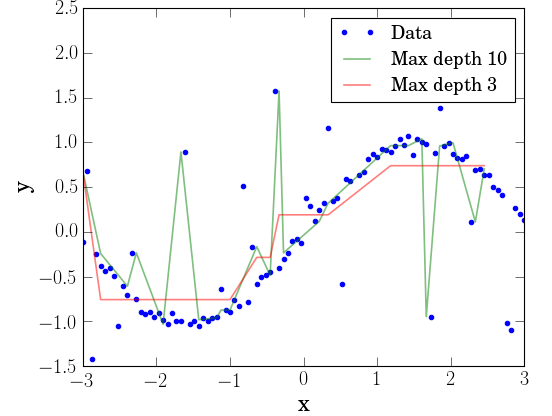

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

y_train = y_train[np.argsort(X_train)]
X_train.sort()
y_test = y_test[np.argsort(X_test)]
X_test.sort()

X_train = X_train[:, None] # sklearn doesn't like 1d X arrays
X_test = X_test[:, None]


dt1 = DecisionTreeRegressor(max_depth=10) # An overly complicated classifier
dt2 = DecisionTreeRegressor(max_depth=3) # A simpler classifier


dt1.fit(X_train, y_train)
dt2.fit(X_train, y_train)

y_train_1 = dt1.predict(X_train)
y_train_2 = dt2.predict(X_train)


y_test_1 = dt1.predict(X_test)
y_test_2 = dt2.predict(X_test)


plt.figure()
plt.plot(x,y,'.')
plt.plot(X_test, y_test_1, lw=1.5, alpha=0.5)
plt.plot(X_test,y_test_2, lw=1.5, alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.legend(('Data', 'Max depth 10', 'Max depth 3'));

You can see the more complicated decision tree learns the behaviour of the spurious outliers. It's easy to check for over-fitting, whatever metric you're using (in this case mean squared error) will show much higher performance on the training than on the test set.

In [30]:
mse_train = np.mean((y_train-y_train_1)**2)
mse_test = np.mean((y_test-y_test_1)**2)
mse_train, mse_test

(0.00014132110849626481, 0.54564383525361615)

In [31]:
mse_train = np.mean((y_train-y_train_2)**2)
mse_test = np.mean((y_test-y_test_2)**2)
mse_train, mse_test

(0.1934993327434579, 0.13793736239832607)

We'll now use cross validation to automatically choose the hyperparameters and avoid over-fitting

In [32]:
dt3 = GridSearchCV(DecisionTreeRegressor(), param_grid={'max_depth': np.arange(2,12)}, cv=5)
dt3.fit(X_train, y_train)

y_train_3 = dt3.predict(X_train)
y_test_3 = dt3.predict(X_test)

mse_train = np.mean((y_train-y_train_3)**2)
mse_test = np.mean((y_test-y_test_3)**2)
mse_train, mse_test

(0.26459745630740678, 0.20175110292504578)

In [33]:
print(dt3.best_params_)

{'max_depth': 2}


Why does it choose max_depth=2 when we found max_depth=3 gave a better MSE? Because Decision Trees are high-variance, meaning they're very sensitive to the exact choice of training and validation set so our previous result isn't general. This highlights why you need cross-validation and why Decision Trees alone aren't very good.

### Commentary on over-fitting

The overly-complicated model overfits the data, incorporating noise into the model. The easiest way to see if you're overfitting is to compare whatever metric you're using (e.g. mean-square-error or AUC) between training and test sets. Usually these numbers should be fairly similar. If performance is significantly higher in the training set, you're overfitting. 

To avoid overfitting: 
1. Always keep a separate test set that you don't touch when fiddling with algorithms
2. Use cross-validation to optimise hyper-parameters
3. Use algorithms that are more robust to over-fitting (e.g. Random Forests)

Note: The above numbers are sensitive to the random seed used and exact data set (change it and see) but on average you'll see the decision tree with higher max depth will tend to overfit.

## Next steps

.You can try the same thing with a different algorithm (just look up a few on scikit learn), have a look at a regression problem which works in a similar way or for some real fun, try out a different dataset!